# CM50268 :: Final project

**Total Marks 25 (25% of overall unit grade).** 

*Submission deadline: 8pm, May 03, 2024. Please submit this file along with your individual report in Moodle*

## Submission & Marking

This exercise is assessed, and the marks will contribute to your final grade. For this exercise there are a number of places where you are expected to enter your own code. Please see the BML Final Project Specification document for details. 

Every place you have to add code is described in the text and specifically indicated by the comment:

`#### **** YOUR CODE HERE **** ####`


The workbook you submit must be this `.ipynb` file, which is saved into the directory you're running Jupyter; alternatively you can download it from the menu above using `File -> Download As -> Notebook (.ipynb)`. Remember to save your work regularly (Save and Checkpoint in the File menu, the icon of a floppy disk, or Ctrl-S); the version you submit should have all code blocks showing the results (if any) of execution below them.

**You should take care to avoid any suggestion of plagiarism in your submission.** There is helpful information on how to avoid plagiarism on the University website: http://www.bath.ac.uk/library/help/infoguides/plagiarism.html

# Project setup

This coursework involves the evaluation of Bayesian modelling methods on a real multivariate regression task. Please check the pdf file for the details of the project.

- <font color=Red> Please try to use fixed random seeds to make your results reproducible </font>

- <font color=Red> Please do NOT change the name of the fixed variables, as Task 2 - Task 5 of this coding exercises are auto-marked </font>

The marks for Task 1 will be awarded based only on the content of the report.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import hmc_Lab as hmc

# Task 1 : Exploratory analysis (Section 4.1 in the specification doc)

Undertake an initial exploratory analysis of the training data and summarise. Code in Task 1 will NOT by auto-marked. Results of Task 1 will be assessed along with your individual report, i.e., 4 marks in total. 

 - <font color=Red> Please perserve the variables `X_train` and  `y_train` representing the normalised data in numpy array, as required for the following exercises  </font>

 - `X_train` is an np.array with shape (384, 9). The 1st column is a constant (bias) $x_0$ and the 2nd to the 9th columns are data variables $x_1,x_2,\dots,x_8$

 - `y_train` is also an np.array with shape (384,), representing the target variable $y$ 
 
 -  Please utilize zero-mean normalization on `X_train`and <font color=Red>refrain</font> from applying any normalization technique to obtain `y_train`.
  

In [14]:
#### **** YOUR CODE HERE **** ####  
import csv
train=pd.read_csv('ee-train.csv',header=None)
test=pd.read_csv('ee-test.csv',header=None)
X_train=train.iloc[1:,:9]
X_test=test.iloc[1:,:9]

X_train=np.array(X_train).astype(float)
X_test=np.array(X_test).astype(float)
for i in range(1,len(X_train.T)):
    X_train.T[i] = (X_train.T[i] - np.mean(X_train.T[i])) / np.std(X_train.T[i])

for i in range(1,len(X_test.T)):
    X_test.T[i] = (X_test.T[i] - np.mean(X_test.T[i])) / np.std(X_test.T[i])
y_train=train.iloc[1:,9]
y_train=np.array(y_train).astype(float)

y_test=test.iloc[1:,9]
y_test=np.array(y_test).astype(float)
#X_train[:3]
#### **** You can add extra cells to illustrate your results **** ####  

In [15]:
# Check whether fixed variables are correctly defined ..
try:
    if not isinstance(X_train,np.ndarray):
        print('X_train should be an array')        
    if X_train.shape != (384,9):
        print('X_train is arranged in wrong shape')
except Exception as err:
    print('Error output:', err)
    
try:
    if not isinstance(y_train,np.ndarray):
        print('y_train should be an array')        
    if y_train.shape != (384,):
        print('y_train is arranged in wrong shape')
    if y_train.mean()<10:
        print('Do not apply any normalization technique to obtain `y_train`')
except Exception as err:
    print('Error output:', err)

#  Task 2 : Type-2 maximum likelihood (Section 4.2 in the specification doc)

###  **(6 marks for coding part)**

Precisions are defined as: $\alpha = 1 / \sigma_w^2$ and $ \beta = 1 / \sigma_{\epsilon}^2 $

Assume priors of $\alpha$ and $\beta$ follow flat Uniform distributions, please derive a likelihood function $(y|\alpha, \beta)$ (`compute_log_marginal`) to compute the *log-ikelihood* for the Bayesian linear regression problem using $X$ and hyperparameters $\alpha$ and $\beta$. 

In Lecture 4, we have illustrated the equations of finding the most probable hyperparameters to maximise the likelihood with respect to the hyperparameters.


`X`: this is an np.array equivalent to matrix $X$ in the specification doc, e.g., `X_train`, `X_test`.

`y`: this is an np.array equivalent totarget $y$ in the specification doc, e.g., `y_train`, `y_test`.


In [16]:
## Compute log-likelihood

def compute_log_marginal(X, y, alph, beta):
    ### **** YOUR CODE HERE **** ####   
    cov=1/beta*np.identity(X.shape[0])+(alph**-1)*X@X.T
    lgp=stats.multivariate_normal.logpdf(y.T,None,cov,allow_singular=True)
    return lgp

Compute log-evidence (marginal likelihood) `log_prob_y` and plot the 'contourf' of the log-posterior distribution.

- The x-axis should be the value of $log \alpha$ and y-axis the $log\beta$, `log_prob_y` represents the log-evidence. For each axis, it is recommended to use 
`np.linspace(-5,0,100)`

- It is strongly recommended that you use only natural logarithms for hyper-parameter scales. That is, you would use `numpy.exp()` and `numpy.log()` functions to convert (or to convert back) the logarithm terms, <font color=Red> which is different from the previous coursework Part2</font>.

In [17]:
#### **** YOUR CODE HERE **** ####   

log_alpha_values = np.linspace(-5, 0, 100)
alpha_values = np.exp(log_alpha_values)
log_beta_values = np.linspace(-5, 0, 100)
beta_values = np.exp(log_beta_values)
log_prob_y = np.zeros((100, 100))

for i in range(100):
    print(i)
    for j in range(100):
        log_prob_y[i, j] = compute_log_marginal(X_train, y_train, alpha_values[j], beta_values[i])

# Check whether your variables are correctly defined ..
try:
    if not isinstance(log_prob_y,np.ndarray):
        print('log_prob_y should be an array')        
    if log_prob_y.shape != (100,100):
        print('log_prob_y is arranged in a wrong shape')
except Exception as err:
    print('Error output:', err)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Print out the most proboble values of the parameters $\alpha$ and $\beta$ and the corresponding log-likelihood value.

In [24]:
#### **** YOUR CODE HERE **** ####
# Get the index of the maximum log-likelihood value
max_index=np.unravel_index(np.argmax(log_prob_y),log_prob_y.shape)
print(max_index)

# Get the corresponding values of alpha and beta
alph_mesh,beta_mesh=np.meshgrid(alpha_values,beta_values)
alpha = alph_mesh[max_index[0],max_index[1]]
beta = beta_mesh[max_index[0],max_index[1]]

# Get the corresponding log-likelihood value
log_likelihood = log_prob_y[max_index]

# Print the results
print("Most probable values:")
print("Alpha:", alpha)
print("Beta:", beta)
print("Log-Likelihood:", log_likelihood)


(55, 11)
Most probable values:
Alpha: 0.01174362845702136
Beta: 0.10836802322189586
Log-Likelihood: -1001.4576252255197


Visualisation using `plt.contourf`for the posterior distribution and indicate the most probable value (with a highlighted marker) in the graph.

<Figure size 640x480 with 0 Axes>

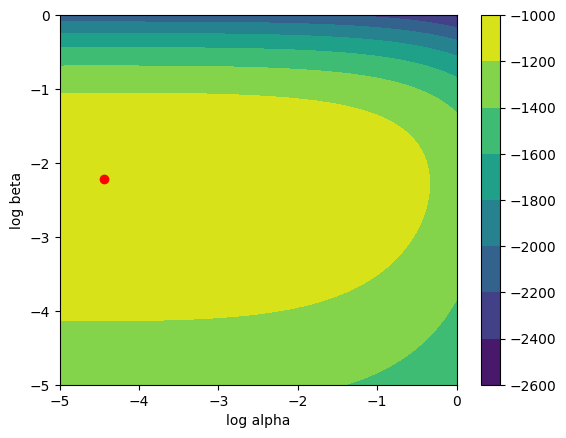

<Figure size 640x480 with 0 Axes>

In [19]:
#### **** YOUR CODE HERE **** ####   
import matplotlib.pyplot as plt

plt.contourf(log_alpha_values,log_beta_values,log_prob_y)
plt.plot(np.log(alpha),np.log(beta),'ro')
plt.xlabel('log alpha')
plt.ylabel('log beta')

plt.colorbar()

plt.figure()


Write a function `compute_posterior(X, y, alph, beta)`  to compute the posterior mean $\mathbf{\mu}$ (`Mu`) and covariance $\mathbf{\Sigma}$ (`SIGMA`) for the Bayesian linear regression model, and return `Mu` and `SIGMA` for the posterior in the np.array format. 

In [25]:
def compute_posterior(X, y, alph, beta):
    #### **** YOUR CODE HERE **** ####
    Mu=np.linalg.inv(X.T @ X + 1/beta*alph*np.identity(X.shape[1]))@X.T@y
    SIGMA=np.linalg.inv(X.T @ X + 1/beta*alph*np.identity(X.shape[1]))*1/beta
    return Mu, SIGMA

Calculate the predicted weights and print out the corresponding RMSE for training and test sets.

In [26]:
#### **** YOUR CODE HERE **** ####

# lam = 10** (np.exp(log_likelihood))
# alpha = lam/(1/beta_values)

mu_train, sigma_train = compute_posterior(X_train, y_train, alpha, beta)
Mu_test, sigma_test = compute_posterior(X_test, y_test, alpha, beta)

y_train_pred=X_train@mu_train
y_test_pred=X_test@Mu_test

def rmse(pred, values):
    return np.sqrt(np.mean((pred - values) ** 2))

rmse_train = rmse(y_train_pred, y_train)
rmse_test = rmse(y_test_pred, y_test)

print("RMSE train:", rmse_train)
print("RMSE test:", rmse_test)

RMSE train: 3.011694589752801
RMSE test: 2.80639813070267


# Task 3: Verify HMC on a standard 2D Gaussian example (Section 4.3 in the specification doc)

###  **(4 marks for coding part)**

## The "Distribution"

Complete the following functions:

- `energy_func(x)`: the energy function, return negative log pdf value in float format
- `energy_grad(x)`: the gradient function returns a numpy array containing the partial derivatives of the energy function with respect to the parameters/hyper-parameters.
- `covar`: Covariance matrix for 2-dimensional gaussian. It is an numpy array with shape (2,2), e.g,  np.array([[1.0875,1],[1,1.0875]]) 

- `R`: the number of samples desired
- `L`: number of simulation steps; for this simple case, 20 is easily enough
- `eps`: simulation step length; set by trial-and-error to give approx. 90% acceptance
- `burn`: simply set to `R/10`
- `checkgrad`: set to true to test the consistency of `energy_func` and `energy_grad`



In [ ]:
def energy_func(x, covar):
    #### **** YOUR CODE HERE **** ####
    
    return neglgp

def energy_grad(x, covar):
    #### **** YOUR CODE HERE **** ####
    
    
    return g



## Visualising the Distribution
Before we run the sampler, let's visualise the distribution over an appropriate
grid of values. Please specify `covar` to plot figures, an naive example of `covar` has been shown below

In [ ]:

#### **** YOUR CODE BELOW **** ####

covar = np.array([[1,0.9],[0.9,1]]) 

#### **** YOUR CODE ABOVE **** ####

f = 5  # The "frequency" argument for the energy, used here to demonstrate how to use "args"
# Other plotting parameters
fsz = (10,8)
gsz = 100
lim = 3

# Setup the mesh grid

gx = np.linspace(-lim, lim, gsz)
GX, GY = np.meshgrid(gx, gx)
Gsz = GX.size
G = np.hstack((GX.reshape((Gsz, 1)), GY.reshape((Gsz, 1))))

# Plot the figure
plt.figure(figsize=fsz)
P = np.asarray([np.exp(-energy_func(g, covar)) for g in G])
plt.contour(GX, GY, P.reshape((gsz, gsz)), cmap='Reds', linewidths=3, zorder=1);

In [ ]:
try:
    if not isinstance(covar ,np.ndarray):
        print('covar  should be an array')        
    if covar .shape != (2,2):
        print('covar  is arranged in wrong shape')
except Exception as err:
    print('Error output:', err)

In [ ]:
# Initialise the state for the first time step
x0 = np.random.normal(size=2)

# Call the function from the pre-defined hmc module
hmc.gradient_check(x0, energy_func, energy_grad, covar)

## Hyper-parameters

Please tune optimal hyper-parameters incluidng `R`, `L`, and `eps` in the cell below. 

In [ ]:
np.random.seed(seed=1)  # Fix the random seed for better reproducibility

#### **** YOUR CODE BELOW **** ####


# R=
# L = 
# eps = 
# burn = 

#### **** YOUR CODE ABOVE **** ####

# HMC sampling
S, *_ = hmc.sample(x0, energy_func, energy_grad, R, L, eps, burn=burn, checkgrad=True, args=[covar])
# Plot the figure
plt.figure(figsize=fsz)
plt.plot(S[:, 0], S[:, 1], '.', ms=6, color='CadetBlue', alpha=0.25, zorder=0)
plt.contour(GX, GY, P.reshape((gsz, gsz)), cmap='Reds', linewidths=3, zorder=1);

In [ ]:
#### **** YOUR CODE HERE **** ####

#### **** You can add extra figures to support the individual report **** ####

# Task 4: Apply HMC to the Linear Regression Model (Section 4.4 in the specification doc)

###  **(6 marks for coding part)**

Complete the functions and the HMC code for this task:

- `energy_func_lr(hps, x, y)`: where `hps` is a 2+9 dimension array, where the 1st dimension represents $\alpha$, and the 2nd represnets $\beta$. Thus, `hps[0]` should be the current $\alpha$, `hps[1]` the $\beta$ and `hps[2:]` represent the weights `w` for constant and 8 variables respectively. `x` and `y` is the x and y array of training data.

- `energy_grad_lr(hps, x, y)`: the gradient function returns an array containing the partial derivatives of the energy function. should be the same shape for hps. 

- `R`: the number of samples desired
- `L`: number of simulation steps; for this simple case, 20 is easily enough
- `eps`: simulation step length; set by trial-and-error to give approx. 90% acceptance
- `burn`: simply set to `R/10`
- `checkgrad`: set to true to test the consistency of `energy_func` and `energy_grad`




In [ ]:
def energy_func_lr(hps, x, y):
    #### **** YOUR CODE HERE **** ####
    
    return neglgp

In [ ]:
def energy_grad_lr(hps, x, y):
    
    #### **** YOUR CODE HERE **** ####

    return g

In [ ]:
np.random.seed(seed=1) 

#### **** YOUR CODE HERE **** ####



#### you can adjust the hpyer-parameters. 


S, *_ = hmc.sample(x0, energy_func_lr, energy_grad_lr, R, L, eps, burn=burn, checkgrad=True, args=[X_train, Y_train])

## Print out the RMSE and plot figures for your report

In [ ]:
#### **** YOUR CODE HERE **** ####

# Task 5: Apply HMC as a Classifier (Section 4.5 in the specification doc)

###  **(5 marks for the coding part)**

There's no restriction on the classifier implementation, please follow the instricution/hints in the specification document. You may receive 1 extra bonus mark depending on the quality of implementation.  


    
    


# Task 6: Variational Inference (Section 4.6 in the specification doc)

###  **(4 marks for coding part)**

Write a Variational Inference function `VI(X_train, Y_train)` and return parameter estimates. 

The returned terms should include:

`an`, `bn`, `cn`, `dn`: float

`mn_n`: np.array, shape = (9,),

`sig_n`: np.array, shape = (9,9),

where

`an` and `bn` are the hyper-parameters for $w\propto  N(w|0,\alpha)$,  $\alpha\propto Gamma(\alpha|a,b) $. 

`cn` and `dn` are the hyper-parameters for gaussian noise $N(0,\beta)$,  $\beta\propto Gamma(\beta|c,d) $.

`mn_n` and `sig_n` are the mean $\mathbf{\mu}$ and covariance $\mathbf{\Sigma}$ of the posterior distribution w.r.t. $w$ (in this task) for the Bayesian linear regression model.

<font color=Red> The corresponding derivations should be completed in your report.</font>



In [ ]:
def VI(X_train, Y_train):
    #### **** YOUR CODE HERE **** ####

    
    
    return an,bn,cn,dn, mu_n, sig_n


Print out the expectation of $\alpha$ and $\beta$ as `exp_alpha`,`exp_beta`. 

In [ ]:
try:
    an,bn,cn,dn, mu_n, sig_n = VI(X_train, Y_train)
except Exception as err:
    print('Error output:', err)
    
#### Print out the expectation of alpha and beta
#### **** YOUR CODE HERE **** ####


In [ ]:
# Check whether your variables are correctly defined  ..
try:
    if not isinstance(mu_n,np.ndarray):
        print('mu_n should be an array')        
    if mu_n.shape != (9,):
        print('mu_n is arranged in wrong shape')
except Exception as err:
    print('Error output:', err)
    
try:
    if not isinstance(sig_n,np.ndarray):
        print('sig_n should be an array')        
    if sig_n.shape != (9,9):
        print('sig_n is arranged in wrong shape')
except Exception as err:
    print('Error output:', err)
    
try:
    exp_alpha
    exp_beta
except Exception as err:
    print('Error output:', err)

Calculate the RMSE for training and test sets.

In [ ]:
#### **** YOUR CODE HERE **** ####
